# Dataset & Model

In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np
import random

import os
from collections import defaultdict

import os

class ImageDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = classes
        self.class_to_label = {c: i for i, c in enumerate(self.classes)}
        self.image_paths, self.labels = self._get_image_paths_and_labels()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")  # Open as grayscale
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

    def _get_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".jpeg"):
                    image_path = os.path.join(root, file)
                    label = os.path.basename(os.path.dirname(image_path))
                    if label in self.classes:
                        image_paths.append(image_path)
                        labels.append(self.class_to_label[label])
        return image_paths, labels

In [2]:
#Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
import notify_run
# Create a notification endpoint
notify = notify_run.Notify()
notify.register()

Endpoint: https://notify.run/3wJAZVSkjFtWNN29ZK7J
To subscribe, open: https://notify.run/c/3wJAZVSkjFtWNN29ZK7J
Or scan this QR code:

                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              
                                                              

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from sklearn.preprocessing import LabelEncoder

import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((7, 7))
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

root_dir = "data/"
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  #Convert to grayscale
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

classes = ["cane", "cavallo", "elefante", "farfalla", "gallina", "gatto", "mucca", "pecora", "ragno", "scoiattolo"]

dataset = ImageDataset(root_dir=root_dir, classes=classes, transform=transform)

num_classes = len(classes)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

#Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [5]:
for images, labels in train_dataloader:
    print(labels)
    break

tensor([3, 2, 8, 8, 2, 8, 8, 2, 8, 9, 1, 5, 8, 1, 3, 0])


# Training

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNClassifier(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 200

#Training loop
best_val_loss = float('inf')
best_model_path = "best_validation_model_classify.pt"
no_improvement_epochs = 0

best_accuracy = 0
max_no_improvement_epochs = 10

for epoch in range(num_epochs):
    model.train() 
    train_loss = 0.0

    #tqdm for progress bar
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        progress_bar.set_postfix({"Train Loss": loss.item()})

    train_loss /= len(train_dataset)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_dataset)
    accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

    #Early stopping
    if accuracy <= best_accuracy:
        no_improvement_epochs += 1
    else:
        no_improvement_epochs = 0
        best_accuracy = accuracy
        torch.save(model.state_dict(), best_model_path)

        #Upload accuracy to notify.run
        notify.send(f"New best accuracy achieved: {accuracy:.2f}%")

    if no_improvement_epochs >= max_no_improvement_epochs:
        print(f"No improvement in accuracy for {no_improvement_epochs} epochs. Stopping early.")
        notify.send("Training Completed.")
        break

    progress_bar.close()

Epoch [1/200], Train Loss: 1.8465, Val Loss: 1.5917, Accuracy: 45.01%


Epoch [2/200], Train Loss: 1.4577, Val Loss: 1.2940, Accuracy: 52.81%


Epoch [3/200], Train Loss: 1.2582, Val Loss: 1.3482, Accuracy: 54.42%


Epoch [4/200], Train Loss: 1.1273, Val Loss: 0.9806, Accuracy: 66.42%


Error sending notification: HTTPSConnectionPool(host='notify.run', port=443): Max retries exceeded with url: /3wJAZVSkjFtWNN29ZK7J (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002239223B460>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))


Epoch [5/200], Train Loss: 1.0205, Val Loss: 0.8756, Accuracy: 70.09%


Epoch [6/200], Train Loss: 0.9211, Val Loss: 0.9315, Accuracy: 68.52%


Epoch [7/200], Train Loss: 0.8497, Val Loss: 0.8432, Accuracy: 72.12%


Epoch [8/200], Train Loss: 0.7828, Val Loss: 0.7714, Accuracy: 74.28%


Epoch [9/200], Train Loss: 0.7144, Val Loss: 0.7232, Accuracy: 75.62%


Epoch [10/200], Train Loss: 0.6633, Val Loss: 0.6989, Accuracy: 76.27%


Epoch [11/200], Train Loss: 0.6197, Val Loss: 0.6241, Accuracy: 79.22%


Epoch [12/200], Train Loss: 0.5790, Val Loss: 0.6149, Accuracy: 79.76%


Epoch [13/200], Train Loss: 0.5380, Val Loss: 0.6065, Accuracy: 80.35%


Epoch [14/200], Train Loss: 0.5067, Val Loss: 0.5412, Accuracy: 82.17%


Epoch [15/200], Train Loss: 0.4732, Val Loss: 0.5212, Accuracy: 82.85%


Epoch [16/200], Train Loss: 0.4408, Val Loss: 0.5116, Accuracy: 83.22%


Epoch [17/200], Train Loss: 0.4164, Val Loss: 0.4932, Accuracy: 83.89%


Epoch [18/200], Train Loss: 0.3908, Val Loss: 0.4680, Accuracy: 84.40%


Epoch [19/200], Train Loss: 0.3619, Val Loss: 0.5131, Accuracy: 83.83%


Epoch [20/200], Train Loss: 0.3335, Val Loss: 0.4184, Accuracy: 86.41%


Epoch [21/200], Train Loss: 0.3219, Val Loss: 0.4137, Accuracy: 86.61%


Epoch [22/200], Train Loss: 0.3061, Val Loss: 0.4939, Accuracy: 84.27%


Epoch [23/200], Train Loss: 0.2769, Val Loss: 0.4507, Accuracy: 86.07%


Epoch [24/200], Train Loss: 0.2589, Val Loss: 0.4056, Accuracy: 87.64%


Epoch [25/200], Train Loss: 0.2530, Val Loss: 0.4747, Accuracy: 86.30%


Epoch [26/200], Train Loss: 0.2339, Val Loss: 0.3863, Accuracy: 88.23%


Epoch [27/200], Train Loss: 0.2213, Val Loss: 0.4669, Accuracy: 86.15%


Epoch [28/200], Train Loss: 0.2002, Val Loss: 0.4762, Accuracy: 86.61%


Epoch [29/200], Train Loss: 0.1901, Val Loss: 0.3996, Accuracy: 87.87%


Epoch [30/200], Train Loss: 0.1781, Val Loss: 0.3897, Accuracy: 88.96%


Epoch [31/200], Train Loss: 0.1673, Val Loss: 0.4543, Accuracy: 87.72%


Epoch [32/200], Train Loss: 0.1570, Val Loss: 0.3923, Accuracy: 88.94%


Epoch [33/200], Train Loss: 0.1469, Val Loss: 0.4503, Accuracy: 88.23%


Epoch [34/200], Train Loss: 0.1386, Val Loss: 0.4759, Accuracy: 88.67%


Epoch [35/200], Train Loss: 0.1303, Val Loss: 0.4055, Accuracy: 89.27%


Epoch [36/200], Train Loss: 0.1218, Val Loss: 0.4731, Accuracy: 87.60%


Epoch [37/200], Train Loss: 0.1209, Val Loss: 0.4019, Accuracy: 89.17%


Epoch [38/200], Train Loss: 0.1092, Val Loss: 0.3961, Accuracy: 89.71%


Epoch [39/200], Train Loss: 0.1036, Val Loss: 0.4385, Accuracy: 89.02%


Epoch [40/200], Train Loss: 0.0987, Val Loss: 0.4451, Accuracy: 88.79%


Epoch [41/200], Train Loss: 0.1008, Val Loss: 0.4431, Accuracy: 89.09%


Epoch [42/200], Train Loss: 0.0905, Val Loss: 0.4341, Accuracy: 89.69%


Epoch [43/200], Train Loss: 0.0906, Val Loss: 0.4263, Accuracy: 89.00%


Epoch [44/200], Train Loss: 0.0829, Val Loss: 0.3970, Accuracy: 89.97%


Epoch [45/200], Train Loss: 0.0850, Val Loss: 0.4248, Accuracy: 90.09%


Epoch [46/200], Train Loss: 0.0766, Val Loss: 0.4340, Accuracy: 89.25%


Epoch [47/200], Train Loss: 0.0781, Val Loss: 0.5096, Accuracy: 89.09%


Epoch [48/200], Train Loss: 0.0703, Val Loss: 0.5613, Accuracy: 87.75%


Epoch [49/200], Train Loss: 0.0688, Val Loss: 0.6010, Accuracy: 89.57%


Epoch [50/200], Train Loss: 0.0725, Val Loss: 0.4503, Accuracy: 88.90%


Epoch [51/200], Train Loss: 0.0640, Val Loss: 0.5357, Accuracy: 87.89%


Epoch [52/200], Train Loss: 0.0618, Val Loss: 0.4771, Accuracy: 89.69%


Epoch [53/200], Train Loss: 0.0648, Val Loss: 0.4638, Accuracy: 90.13%


Epoch [54/200], Train Loss: 0.0635, Val Loss: 0.4935, Accuracy: 89.59%


Epoch [55/200], Train Loss: 0.0543, Val Loss: 0.5343, Accuracy: 89.28%


Epoch [56/200], Train Loss: 0.0538, Val Loss: 0.7718, Accuracy: 87.60%


Epoch [57/200], Train Loss: 0.0830, Val Loss: 0.4789, Accuracy: 89.69%


Epoch [58/200], Train Loss: 0.0519, Val Loss: 0.5081, Accuracy: 89.78%


Epoch [59/200], Train Loss: 0.0429, Val Loss: 0.5519, Accuracy: 88.14%


Epoch [60/200], Train Loss: 0.0524, Val Loss: 0.5612, Accuracy: 88.90%


Epoch [61/200], Train Loss: 0.0515, Val Loss: 0.5032, Accuracy: 89.57%


Epoch [62/200], Train Loss: 0.0476, Val Loss: 0.5104, Accuracy: 89.23%


Epoch [63/200], Train Loss: 0.0480, Val Loss: 0.4588, Accuracy: 89.84%
No improvement in accuracy for 10 epochs. Stopping early.


# Evaluation & Down-projection

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNClassifier(num_classes).to(device)
model.load_state_dict(torch.load("best_validation_model_classify.pt"))
model.eval()

#Evaluation
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        #print(labels)

100%|██████████████████████████████████████████████████████████████████████████████| 5226/5226 [01:25<00:00, 61.11it/s]


In [8]:
confusion_mat = confusion_matrix(y_true, y_pred)

#percentage of correctly predicted classes per class
correct_per_class = np.diag(confusion_mat) / confusion_mat.sum(axis=1)

classes = ["cane", "cavallo", "elefante", "farfalla", "gallina", "gatto", "mucca", "pecora", "ragno", "scoiattolo"]

for i, correct_percentage in enumerate(correct_per_class):
    class_name = classes[i]
    print(f"{class_name}: {correct_percentage * 100:.2f}% correctly predicted")

cane: 93.47% correctly predicted
cavallo: 92.52% correctly predicted
elefante: 86.55% correctly predicted
farfalla: 86.68% correctly predicted
gallina: 88.87% correctly predicted
gatto: 89.28% correctly predicted
mucca: 86.39% correctly predicted
pecora: 84.81% correctly predicted
ragno: 96.89% correctly predicted
scoiattolo: 87.34% correctly predicted


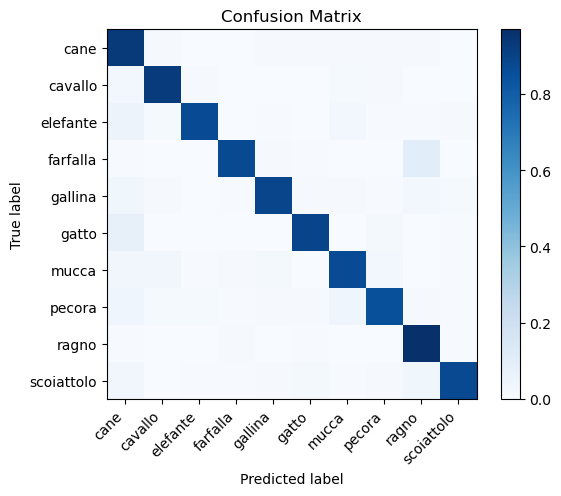

In [9]:
#Normaliation
confusion_mat_norm = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
im = ax.imshow(confusion_mat_norm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(confusion_mat_norm.shape[1]),
       yticks=np.arange(confusion_mat_norm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion Matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [10]:
features = []
labels = []

for images, batch_labels in tqdm(val_dataloader):
    with torch.no_grad():
        outputs = model(images.to(device))
        linear_layer = model.fc_layers[3]
        activations = linear_layer.in_features
        features.append(outputs[:, :activations].cpu().numpy())
        labels.append(batch_labels.numpy())

features = np.concatenate(features)
labels = np.concatenate(labels)


100%|██████████████████████████████████████████████████████████████████████████████| 5226/5226 [01:25<00:00, 61.23it/s]


# T-SNE

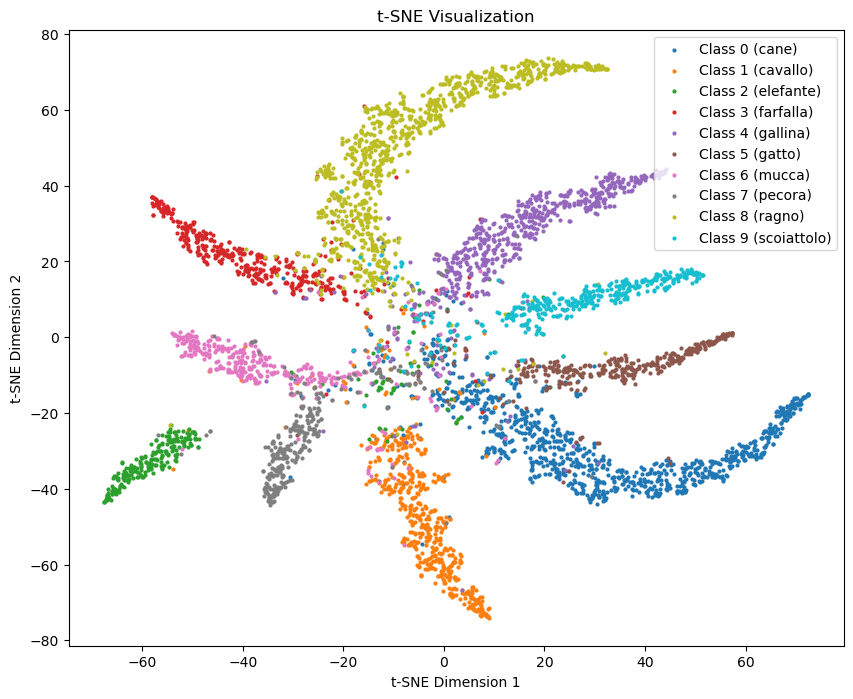

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
projected_features = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
for class_label in range(num_classes):
    class_name = dataset.classes[class_label]
    plt.scatter(
        projected_features[labels == class_label, 0],
        projected_features[labels == class_label, 1],
        label=f'Class {class_label} ({class_name})',
        s=4,  # Adjust the dot size here (default is 20)
    )
plt.legend()
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [12]:
print(set(y_true))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [13]:
print(num_classes)

10
